# **Utils**

In [2]:
!pip install pillow

In [3]:
from PIL import Image, ImageDraw
from IPython.display import display

def draw_boxes(image_path, boxes):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for box in boxes:
        draw.rectangle(box, outline="red", width=3)
    display(image)

In [4]:
def convert_pdf_to_images(pdf_path):
    images = []
    with fitz.open(pdf_path) as doc:
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            pix = page.get_pixmap()
            images.append(pix)
    return images

def encode_image_to_base64(image):
    image_bytes = image.tobytes()
    base64_encoded = base64.b64encode(image_bytes)
    base64_string = base64_encoded.decode("utf-8")
    return base64_string

In [5]:
def calculate_scaling_factors(extracted_bbox, ground_truth_bbox):
    extracted_width = extracted_bbox[2] - extracted_bbox[0]
    extracted_height = extracted_bbox[3] - extracted_bbox[1]
    ground_truth_width = ground_truth_bbox[2] - ground_truth_bbox[0]
    ground_truth_height = ground_truth_bbox[3] - ground_truth_bbox[1]

    scale_x = ground_truth_width / extracted_width
    scale_y = ground_truth_height / extracted_height
    print(scale_x, scale_y)

    return scale_x, scale_y

def apply_scaling(bbox, scale_x, scale_y):
    x1 = bbox[0] * scale_x
    y1 = bbox[1] * scale_y
    x2 = bbox[2] * scale_x
    y2 = bbox[3] * scale_y
    return [x1, y1, x2, y2]

def scale_bounding_boxes(extracted_boxes, ground_truth_boxes):
    scaled_boxes = []
    for extracted_page, ground_truth_page in zip(extracted_boxes, ground_truth_boxes):
        if not extracted_page or not ground_truth_page:
            # If either page is empty, add empty list and continue
            scaled_boxes.append([])
            continue

        # Calculate scaling factors based on the first bounding box pair of the current page
        scale_x, scale_y = calculate_scaling_factors(extracted_page[0], ground_truth_page[0])

        scaled_page = [apply_scaling(bbox, scale_x, scale_y) for bbox in extracted_page]
        scaled_boxes.append(scaled_page)

    return scaled_boxes

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    intersection_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

def match_bounding_boxes(gt_boxes, pred_boxes):
    matched_ious = []
    used_predictions = set()
    for gt_box in gt_boxes:
        best_iou = 0
        best_pred_idx = -1
        for i, pred_box in enumerate(pred_boxes):
            if i in used_predictions:
                continue
            iou = calculate_iou(gt_box, pred_box)
            if iou > best_iou:
                best_iou = iou
                best_pred_idx = i
        if best_pred_idx >= 0:
            used_predictions.add(best_pred_idx)
            matched_ious.append(best_iou)
        else:
            matched_ious.append(0)
    return matched_ious

def evaluate_models(ground_truth, predictions):
    model_ious = {}
    for model, pred_boxes in predictions.items():
        ious = []
        for gt_boxes, model_boxes in zip(ground_truth, pred_boxes):
            matched_ious = match_bounding_boxes(gt_boxes, model_boxes)
            ious.extend(matched_ious)
        model_ious[model] = np.mean(ious)
    return model_ious

def plot_iou(ground_truth, table_bounding_boxes):
    model_ious = t

    plt.figure(figsize=(13, 6))
    plt.bar(model_ious.keys(), model_ious.values(), color="#568c64")
    plt.xlabel('Models')
    plt.ylabel('Average IoU')
    plt.title('Table Extraction - Model Comparison Based on IoU')
    plt.ylim(0, 1)
    plt.show()

    print(model_ious)

In [7]:
GroundTruth = [
    [[91, 160, 828, 826]], # hardware 1
    [[106, 162, 844, 426], [108, 539, 840, 770]], # hardware 2
    [[553, 125, 1471, 480]], # hardware 3
    [[11, 186, 673, 532], [404, 108, 673, 167]], # bank statement 1
    [[63, 478, 936, 1127]], # bank statement 2
    [[644, 269, 1275, 962]], # bank statement 3
    [[45, 442, 560, 657]], # bank statement 4
    [[81, 458, 458, 825], [489, 745, 748, 805]], # data sheet 3
    [[63, 374, 592, 726]], # invoice 1
    [[44, 340, 611, 456], [44, 502, 611, 702]], # invoice 2
    [[60, 413, 776, 683]], # invoice 3
    [[428, 144, 768, 549]], # real estate listings 2
    [[50, 143, 767, 845]], # real estate listings 3
    [[126, 72, 689, 308], [128, 376, 688, 584], [148, 821, 668, 895]], # research paper 1
    [[23, 366, 791, 769]], # SEC 10k 1
    [[22, 596, 793, 762], [24, 897, 793, 1013]], # SEC 144 1
    [[22, 117, 793, 1022]], # SEC 144 2
    [[94, 101, 592, 267]], # text book 2
    [[223, 102, 721, 398]], # text book 3
]

In [105]:
ground_truth = [
    [[91, 160, 828, 826]],
    [[106, 162, 844, 426], [108, 539, 840, 770]],
    [[553, 125, 1471, 480]]
]

In [1]:
t = {'PyMuPDF': 0.59256987881234, 'GPT 4 Turbo': 0.26977835468383293, 'GPT 4o': 0.27406410283611266, 'Table Transformer': 0.6399495573127585, 'img2table': 0.49895505703101684, 'Gemini Pro': 0.15192114262846507, 'Gemini Flash': 0.17320909579531665}

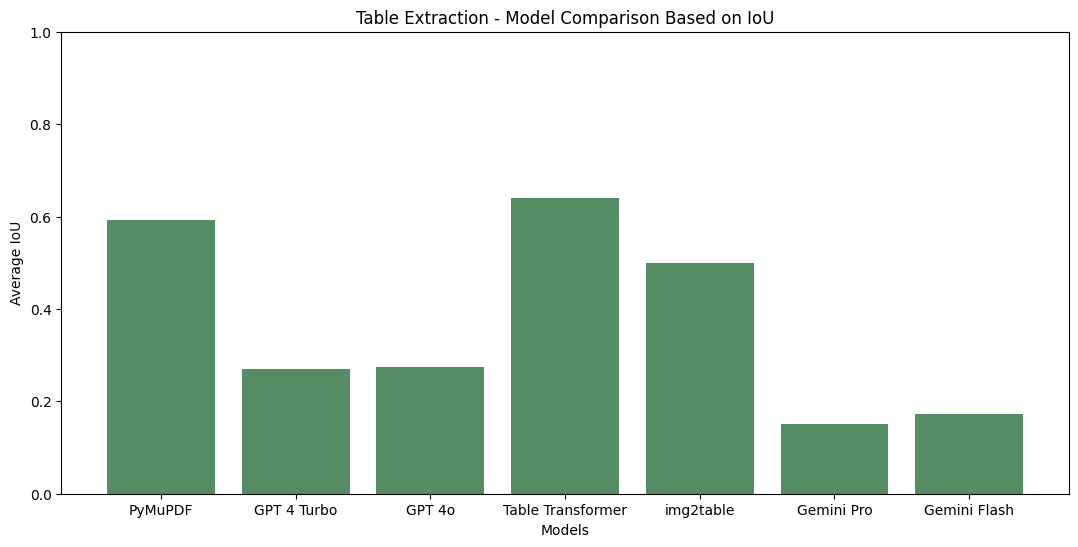

{'PyMuPDF': 0.59256987881234, 'GPT 4 Turbo': 0.26977835468383293, 'GPT 4o': 0.27406410283611266, 'Table Transformer': 0.6399495573127585, 'img2table': 0.49895505703101684, 'Gemini Pro': 0.15192114262846507, 'Gemini Flash': 0.17320909579531665}


In [9]:
plot_iou(GroundTruth, table_bounding_boxes)

# **Table Transformer**

In [7]:
number_of_table_images = 19
table_bounding_boxes = {}

In [ ]:
!pip install timm

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [3]:
def get_bounding_box_table_transformer(image_path):
  image = Image.open(image_path).convert("RGB")

  inputs = image_processor(images=image, return_tensors="pt")
  outputs = model(**inputs)

  target_sizes = torch.tensor([image.size[::-1]])
  results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      print(
          f"Detected {model.config.id2label[label.item()]} with confidence "
          f"{round(score.item(), 3)} at location {box}"
      )
  # draw_boxes(image_path, results["boxes"].tolist())
  return results["boxes"].tolist()

In [68]:
bounding_boxes = []
for image_id in range(1, number_of_table_images+1):
    bounding_boxes.append(get_bounding_box_table_transformer(f"/content/table-{image_id}.png"))

Detected table with confidence 1.0 at location [96.0, 166.24, 822.08, 820.72]
Detected table with confidence 0.999 at location [112.75, 166.88, 817.07, 423.66]
Detected table with confidence 0.998 at location [113.62, 551.71, 717.57, 769.02]
Detected table with confidence 0.991 at location [84.09, 124.33, 1449.32, 477.9]
Detected table with confidence 0.999 at location [13.07, 186.75, 660.28, 508.17]
Detected table with confidence 0.999 at location [96.56, 493.15, 922.1, 1075.55]
Detected table with confidence 0.998 at location [653.11, 278.32, 1266.22, 960.26]
Detected table with confidence 0.999 at location [46.12, 455.55, 553.68, 637.68]
Detected table with confidence 0.999 at location [87.42, 458.74, 435.34, 820.38]
Detected table with confidence 0.971 at location [67.07, 167.88, 589.33, 669.51]
Detected table with confidence 0.985 at location [49.59, 347.63, 550.93, 448.3]
Detected table with confidence 0.997 at location [80.58, 431.38, 759.34, 581.56]
Detected table with confiden

In [74]:
table_bounding_boxes["Table Transformer"] = bounding_boxes

# **Gemini**

In [ ]:
!pip install google-generativeai

In [2]:
import ast
import google.generativeai as genai
from PIL import Image, ImageDraw

In [3]:
genai.configure(api_key= '')
gemini_pro_vision = genai.GenerativeModel('gemini-pro-vision')
genimi_gemini_flash = genai.GenerativeModel('gemini-1.5-flash-latest')
example_image = Image.open("/content/bank_statement_1.png").convert("RGB")
example_bbox = [[404,108,673,167], [11,186,673,532]]
prompt = f"Extract the bounding boxes of all the tables present in this image. Return the bounding boxes as list of lists. Example: For this image -> {example_image} the extracted bounding box is {example_bbox}. This is just an example for understanding the requirement. Dont return the same bounding box."

In [4]:
prompt = f"Extract the bounding boxes of all the tables present in this image. Return the bounding boxes as list of lists. Do not include anyother text or symbols in the output"

In [5]:
def get_bounding_box_gemini(model, image_path):
  img = Image.open(image_path).convert("RGB")
  response = model.generate_content(
      [img, prompt], stream=False
  )
  response.resolve()
  return response.text

In [40]:
temp_b = [[[364, 76, 737, 350], [364, 402, 737, 676], [364, 76, 737, 350], [364, 402, 737, 676]], [[464, 72, 1013, 300], [1116, 72, 1665, 300]], [[434, 63, 784, 301], [434, 320, 784, 558]], [[416, 57, 775, 284], [416, 300, 775, 527]], [[564, 68, 994, 306], [564, 322, 994, 558]], [[416, 77, 737, 1014], [416, 1036, 737, 1272]], [[564, 76, 744, 174], [564, 190, 743, 314], [565, 330, 743, 494], [565, 510, 743, 673]], [], [[516, 148, 734, 304], [516, 320, 735, 477]], [[526, 764, 744, 881]], [[503, 64, 749, 290], [503, 306, 749, 532]], [[545, 72, 1013, 185], [545, 200, 1013, 313], [545, 330, 1013, 442], [545, 458, 1013, 570], [545, 598, 1013, 710], [545, 736, 1013, 848], [545, 868, 1013, 980]], [[515, 77, 1014, 446], [515, 500, 1014, 869]],[[46, 51, 794, 160], [46, 172, 794, 282], [46, 295, 794, 404], [46, 416, 794, 526], [46, 539, 794, 648], [46, 660, 794, 772], [46, 783, 794, 892], [851, 51, 1599, 160], [851, 172, 1599, 282], [851, 295, 1599, 404], [851, 416, 1599, 526], [851, 539, 1599, 648], [851, 660, 1599, 772], [851, 783, 1599, 892]], [[517, 76, 1014, 306], [517, 332, 1014, 561], [517, 588, 1014, 817], [517, 845, 1014, 1072]], [[408, 571, 776, 715], [408, 720, 776, 864], [408, 869, 776, 1013]], [[418.0, 594.0, 756.0, 812.0], [418.0, 100.0, 756.0, 318.0]], [[718, 132, 1039, 794]], [[514, 74, 744, 188]]]

In [9]:
bounding_boxes = []
for image_id in range(11, number_of_table_images+1):
    res = get_bounding_box_gemini(gemini_pro_vision, f"/content/table-{image_id}.png")
    print(image_id, res)
    bounding_boxes.append(ast.literal_eval(res))
bounding_boxes

11  [[503, 64, 749, 290], [503, 306, 749, 532]]
12  [[545, 72, 1013, 185], [545, 200, 1013, 313], [545, 330, 1013, 442], [545, 458, 1013, 570], [545, 598, 1013, 710], [545, 736, 1013, 848], [545, 868, 1013, 980]]
13  [[515, 77, 1014, 446], [515, 500, 1014, 869]]
14  [
  [46, 51, 794, 160],
  [46, 172, 794, 282],
  [46, 295, 794, 404],
  [46, 416, 794, 526],
  [46, 539, 794, 648],
  [46, 660, 794, 772],
  [46, 783, 794, 892],
  [851, 51, 1599, 160],
  [851, 172, 1599, 282],
  [851, 295, 1599, 404],
  [851, 416, 1599, 526],
  [851, 539, 1599, 648],
  [851, 660, 1599, 772],
  [851, 783, 1599, 892]
]
15  [[517, 76, 1014, 306], [517, 332, 1014, 561], [517, 588, 1014, 817], [517, 845, 1014, 1072]]
16  [[408, 571, 776, 715], [408, 720, 776, 864], [408, 869, 776, 1013]]
17  [[418.0, 594.0, 756.0, 812.0], [418.0, 100.0, 756.0, 318.0]]
18  [[718, 132, 1039, 794]]
19  [[514, 74, 744, 188]]


[[[503, 64, 749, 290], [503, 306, 749, 532]],
 [[545, 72, 1013, 185],
  [545, 200, 1013, 313],
  [545, 330, 1013, 442],
  [545, 458, 1013, 570],
  [545, 598, 1013, 710],
  [545, 736, 1013, 848],
  [545, 868, 1013, 980]],
 [[515, 77, 1014, 446], [515, 500, 1014, 869]],
 [[46, 51, 794, 160],
  [46, 172, 794, 282],
  [46, 295, 794, 404],
  [46, 416, 794, 526],
  [46, 539, 794, 648],
  [46, 660, 794, 772],
  [46, 783, 794, 892],
  [851, 51, 1599, 160],
  [851, 172, 1599, 282],
  [851, 295, 1599, 404],
  [851, 416, 1599, 526],
  [851, 539, 1599, 648],
  [851, 660, 1599, 772],
  [851, 783, 1599, 892]],
 [[517, 76, 1014, 306],
  [517, 332, 1014, 561],
  [517, 588, 1014, 817],
  [517, 845, 1014, 1072]],
 [[408, 571, 776, 715], [408, 720, 776, 864], [408, 869, 776, 1013]],
 [[418.0, 594.0, 756.0, 812.0], [418.0, 100.0, 756.0, 318.0]],
 [[718, 132, 1039, 794]],
 [[514, 74, 744, 188]]]

In [23]:
table_bounding_boxes["Gemini Pro"] = temp_b

In [25]:
import re

def parse_bboxs_gemini_flash(input_string):
    lines = [line for line in input_string.strip().split('\n') if line]
    bounding_boxes = [list(map(int, re.findall(r'\d+', line))) for line in lines]
    return bounding_boxes

In [27]:
bounding_boxes = []
for image_id in range(1, number_of_table_images+1):
    res = parse_bboxs_gemini_flash(get_bounding_box_gemini(genimi_gemini_flash, f"/content/table-{image_id}.png"))
    print(image_id, res)
    bounding_boxes.append(res)
bounding_boxes

1 [[94, 112, 818, 880]]
2 [[107, 115, 343, 840], [396, 115, 591, 813]]
3 [[134, 47, 463, 911]]
4 [[342, 15, 952, 967], [222, 616, 284, 965]]
5 [[280, 63, 371, 454], [410, 85, 910, 928]]
6 [[], [], [], [104], [336], [235], [662], [], [], [255], [345], [903], [662], [], [], []]
7 [[608, 67, 892, 928], [342, 78, 400, 569]]
8 [[139, 608, 170, 879], [417, 102, 797, 532], [692, 576, 754, 891], [573, 630, 658, 834]]
9 [[402, 91, 780, 911]]
10 [[354, 78, 500, 862], [526, 74, 761, 890]]
11 [[336, 77, 585, 922]]
12 [[138, 522, 541, 926]]
13 [[148, 69, 798, 932]]
14 [[291, 85, 355, 913], [558, 85, 601, 912], [781, 191, 855, 817], [885, 139, 914, 904]]
15 [[357, 43, 724, 962]]
16 [[543, 38, 697, 923], [833, 39, 964, 942]]
17 [[217, 44, 949, 960]]
18 [[96, 126, 253, 725, 100, 740, 161, 891]]
19 [[116, 277, 367, 861]]


[[[94, 112, 818, 880]],
 [[107, 115, 343, 840], [396, 115, 591, 813]],
 [[134, 47, 463, 911]],
 [[342, 15, 952, 967], [222, 616, 284, 965]],
 [[280, 63, 371, 454], [410, 85, 910, 928]],
 [[],
  [],
  [],
  [104],
  [336],
  [235],
  [662],
  [],
  [],
  [255],
  [345],
  [903],
  [662],
  [],
  [],
  []],
 [[608, 67, 892, 928], [342, 78, 400, 569]],
 [[139, 608, 170, 879],
  [417, 102, 797, 532],
  [692, 576, 754, 891],
  [573, 630, 658, 834]],
 [[402, 91, 780, 911]],
 [[354, 78, 500, 862], [526, 74, 761, 890]],
 [[336, 77, 585, 922]],
 [[138, 522, 541, 926]],
 [[148, 69, 798, 932]],
 [[291, 85, 355, 913],
  [558, 85, 601, 912],
  [781, 191, 855, 817],
  [885, 139, 914, 904]],
 [[357, 43, 724, 962]],
 [[543, 38, 697, 923], [833, 39, 964, 942]],
 [[217, 44, 949, 960]],
 [[96, 126, 253, 725, 100, 740, 161, 891]],
 [[116, 277, 367, 861]]]

In [34]:
scaled_boxes = scale_bounding_boxes(bounding_boxes, GroundTruth)

1.0179558011049723 0.8671875
3.1271186440677967 0.3641379310344828
2.790273556231003 0.41087962962962965
1.0852459016393443 0.3634453781512605
9.593406593406593 1.659846547314578
1.8133802816901408 0.2497096399535424
12.161290322580646 1.3542435424354244
1.3994708994708995 0.4292682926829268
3.8835616438356166 0.14795918367346939
2.8755020080321283 0.31952662721893493
0.8436724565756824 1.0024752475247525
1.103076923076923 0.813441483198146
8.796875 0.28502415458937197
2.092643051771117 0.4385201305767138
5.0064935064935066 0.18757062146892656
1.0532786885245902 0.9879912663755459
3.171974522292994 0.27712854757929883
1.9840637450199203 0.5068493150684932


In [37]:
table_bounding_boxes["Gemini Flash"] = bounding_boxes

# **PyMuPDF**

In [ ]:
!pip install pymupdf

In [76]:
import io
import pymupdf
import fitz

In [89]:
def extract_bounding_box_pymupdf(pdf_path):
    bounding_boxes = []
    pages = pymupdf.open(pdf_path)
    for page_num in range(len(pages)):
        page = pages[page_num]
        tabs = page.find_tables()
        page_tables = []
        for table in range(len(tabs.tables)):
            page_tables.append(list(tabs.tables[table].bbox))
        bounding_boxes.append(page_tables)
    return bounding_boxes

In [92]:
bounding_boxes = extract_bounding_box_pymupdf("/content/table-data.pdf")
bounding_boxes

[[[18.487498389350044,
   19.124998092651367,
   593.9155578613281,
   109.12499237060547]],
 [],
 []]

In [38]:
scaled_boxes = scale_bounding_boxes(bounding_boxes, ground_truth)

2.13103094886968 2.140958468255127
1.690586078570765 5.6974702138220685
2.6620540127239725 2.66533617646015


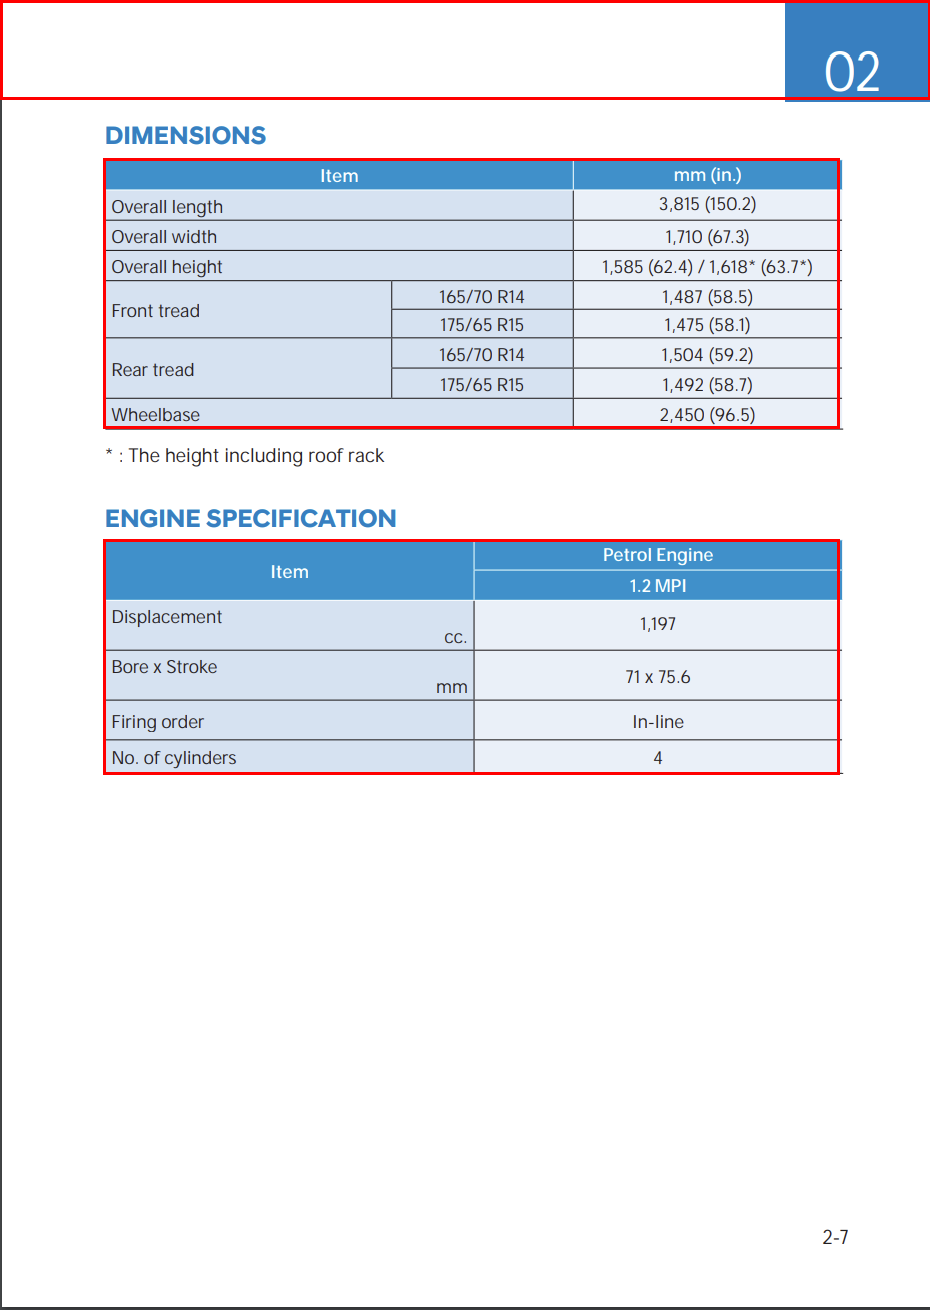

In [41]:
draw_boxes("/content/table-2.png", scaled_boxes[1])

In [44]:
table_bounding_boxes["PyMuPDF"] = scaled_boxes

# **GPT 4**

In [ ]:
!pip install openai

In [28]:
import openai
import fitz
import base64
import requests

In [29]:
openai.api_key = ''
image_media_type = "image/png"

In [30]:
def convert_pdf_to_images(pdf_path):
    images = []
    with fitz.open(pdf_path) as doc:
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            pix = page.get_pixmap()
            images.append(pix)
    return images

def encode_image_to_base64(image):
    image_bytes = image.tobytes()
    base64_encoded = base64.b64encode(image_bytes)
    base64_string = base64_encoded.decode("utf-8")
    return base64_string

In [56]:
example_image = Image.open("/content/bank_statement_1.png").convert("RGB")
example_bbox = [[404,108,673,167], [11,186,673,532]]
prompt = f"Extract the bounding boxes of all the tables present in this image. Return the bounding boxes as list of lists. And don't provide any other text in the response."

In [57]:
def extract_bounding_box_gpt(model, pdf_path):
    images = convert_pdf_to_images(pdf_path)
    extracted_bbox = []
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai.api_key}"
    }

    for image in images:
        base64_string = encode_image_to_base64(image)
        payload = {
            "model": model,
            "messages": [
              {
                "role": "user",
                "content": [
                  {
                    "type": "text",
                    "text": prompt
                  },
                  {
                    "type": "image_url",
                    "image_url": {
                      "url": f"data:image/jpeg;base64,{base64_string}"
                    }
                  }
                ]
              }
            ],
          }

        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        response_json = response.json()

        if "choices" in response_json and len(response_json["choices"]) > 0:
            extracted_bbox.append(ast.literal_eval(response_json["choices"][0]["message"]["content"]))

    return extracted_bbox

In [58]:
extracted_bbox = extract_bounding_box_gpt("gpt-4-turbo", "/content/table-data.pdf")
extracted_bbox

[[[41, 75, 416, 556]],
 [[42, 98, 422, 398], [42, 438, 422, 540]],
 [[91, 92, 704, 293]],
 [[40, 220, 490, 470]],
 [[29, 224, 725, 350], [33, 402, 723, 1026]],
 [[207, 148, 789, 719]],
 [[34, 507, 412, 562], [22, 578, 426, 742]],
 [[68, 199, 343, 236], [67, 248, 342, 366], [65, 374, 343, 517]],
 [[41, 467, 287, 587]],
 [[35, 415, 293, 493], [48, 538, 268, 577]],
 [[35, 335, 385, 480]],
 [[44, 85, 365, 167], [44, 542, 365, 760]],
 [[26, 109, 383, 522]],
 [[22, 284, 385, 858], [22, 902, 385, 1188], [22, 1581, 385, 1833]],
 [[59, 181, 353, 253], [59, 299, 350, 372]],
 [[49, 325, 476, 428], [48, 630, 475, 812], [48, 949, 475, 1032]],
 [[111, 300, 391, 658]],
 [[177, 283, 390, 120]],
 [[108, 375, 309, 618]]]

In [61]:
scaled_boxes = scale_bounding_boxes(extracted_bbox, GroundTruth)

1.9653333333333334 1.3846153846153846
1.9421052631578948 0.88
1.497553017944535 1.7661691542288558
1.471111111111111 1.384
1.2543103448275863 5.150793650793651
1.0841924398625429 1.2136602451838878
1.3624338624338623 3.909090909090909
1.3709090909090909 9.91891891891892
2.1504065040650406 2.933333333333333
2.197674418604651 1.4871794871794872
2.045714285714286 1.8620689655172413
1.0591900311526479 4.939024390243903
2.008403361344538 1.6997578692493946
1.5509641873278237 0.41114982578397213
2.6122448979591835 5.597222222222222
1.8056206088992974 1.6116504854368932
2.7535714285714286 2.5279329608938546
2.3380281690140845 -1.01840490797546
2.4776119402985075 1.2181069958847737


In [46]:
table_bounding_boxes["GPT 4 Turbo"] = scaled_boxes

In [48]:
extracted_bbox = extract_bounding_box_gpt("gpt-4o", "/content/table-data.pdf")
extracted_bbox

[[[41, 118, 488, 403]],
 [[100, 78, 468, 275], [100, 296, 468, 440]],
 [[307, 119, 794, 274]],
 [[32, 379, 321, 394], [31, 102, 504, 373]],
 [[50, 273, 684, 823]],
 [[84, 125, 702, 840]],
 [[25, 157, 247, 340],
  [281, 157, 465, 340],
  [25, 346, 465, 451],
  [22, 472, 465, 675]],
 [[63, 320, 266, 439],
  [63, 447, 265, 525],
  [80, 76, 279, 175],
  [55, 135, 320, 371]],
 [[44, 258, 456, 298],
  [44, 294, 456, 332],
  [44, 331, 456, 369],
  [44, 368, 456, 406],
  [44, 405, 456, 445],
  [44, 442, 456, 480],
  [44, 480, 456, 518],
  [44, 518, 456, 558]],
 [[55, 236, 359, 361], [60, 376, 387, 525], [52, 533, 348, 554]],
 [[52, 308, 518, 434], [52, 444, 243, 474]],
 [[47, 49, 170, 135], [33, 150, 241, 405], [334, 138, 471, 410]],
 [[67, 220, 993, 2001]],
 [[79, 59, 673, 225], [79, 326, 674, 490], [81, 709, 674, 746]],
 [[46, 289, 444, 553]],
 [[50, 181, 563, 266], [50, 278, 729, 335], [50, 352, 729, 413]],
 [[45, 77, 525, 106],
  [25, 108, 545, 165],
  [20, 181, 550, 236],
  [20, 241, 550,

In [51]:
scaled_boxes = scale_bounding_boxes(extracted_bbox, GroundTruth)

1.6487695749440716 2.336842105263158
2.005434782608696 1.3401015228426396
1.8850102669404518 2.2903225806451615
2.290657439446367 23.066666666666666
1.3769716088328077 1.18
1.0210355987055015 0.9692307692307692
2.31981981981982 1.174863387978142
1.8571428571428572 3.0840336134453783
1.2839805825242718 8.8
1.8651315789473684 0.928
1.536480686695279 2.142857142857143
2.7642276422764227 4.709302325581396
0.7742980561555075 0.39416058394160586
0.9478114478114478 1.4216867469879517
1.92964824120603 1.5265151515151516
1.5029239766081872 1.9529411764705882
1.60625 31.20689655172414
1.1266968325791855 1.7473684210526317
1.1745283018867925 1.494949494949495


In [52]:
table_bounding_boxes["GPT 4o"] = scaled_boxes

# **img2table**

In [ ]:
!pip install img2table

In [94]:
from img2table.document import Image

In [95]:
def extract_bounding_box_img2table(image_path):
    img = Image(src=image_path)
    extracted_tables = img.extract_tables()
    bbox_values = [[table.bbox.x1, table.bbox.y1, table.bbox.x2, table.bbox.y2] for table in extracted_tables]
    return bbox_values

In [96]:
bounding_boxes = []
for image_id in range(1, number_of_table_images+1):
    bounding_boxes.append(extract_bounding_box_img2table(f"/content/table-{image_id}.png"))
bounding_boxes

[[[93, 164, 830, 825], [93, 164, 827, 189]],
 [[106, 280, 844, 398], [106, 542, 840, 775], [107, 162, 840, 187]],
 [[78, 511, 513, 655], [553, 128, 1470, 481], [885, 152, 968, 169]],
 [],
 [[65, 481, 934, 1123]],
 [],
 [],
 [[82, 458, 458, 826], [490, 105, 748, 152], [490, 747, 748, 805]],
 [],
 [[46, 342, 609, 454], [46, 505, 608, 701]],
 [[62, 415, 774, 681]],
 [],
 [[49, 194, 768, 844]],
 [[128, 89, 687, 306], [130, 378, 686, 582], [150, 824, 666, 893]],
 [],
 [[26, 26, 791, 186]],
 [],
 [],
 []]

In [102]:
table_bounding_boxes["img2table"] = bounding_boxes

# **ExtractTable**

In [75]:
!pip install -U ExtractTable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.3 MB/s eta 0:00:00


In [ ]:
from ExtractTable import ExtractTable
et_sess = ExtractTable(api_key="")
print(et_sess.check_usage())
# table_data = et_sess.process_file(filepath="/content/table-3.png", output_format="df")
table_data = et_sess.process_file(filepath="/content/tables1-3.pdf", output_format="df", pages="all")

In [144]:
for table in table_data:
    display(table)

0                 1  \
0                                
1                                
2                       Type A   
3                                
4                                
5      Front            Type B   
6                                
7                                
8                       Type C   
9                                
10               Side repeater   
11                  Tail light   
12                  Stop light   
13                 Turn signal   
14      Rear     Back up light   
15            Reflex reflector   
16                High mounted   
17               License plate   
18                    Map lamp   
19  Interior         Room lamp   
20                     Luggage   

                                                    2          3  \
0                                          Light Bulb  Bulb type   
1                                Headlight (high/low)      H19LL   
2                                      Position light        W5W   
3                                   Turn signal light      PY21W   
4                                Headlight (high/low)      H19LL   
5   Position light/ Daytime Running Light (if equi...        LED   
6                                   Turn signal light      PY21W   
7                                Headlight (high/low)     9005HL   
8   Position light/ Daytime Running Light (if equi...        LED   
9                                   Turn signal light      PY21W   
10                           light (outside mirror) *       WY5W   
11                                                           LED   
12                                                        P21/5W   
13                                              light      PY21W   
14                                                          W16W   
15                                                             -   
16                                        stop light*        W5W   
17                                              light        W5W   
18                                                       FESTOON   
19                                                       FESTOON   
20                                 compartment lamp *    FESTOON   

                       4  
0                Wattage  
1                60/55 W  
2                    5 W  
3                   21 W  
4                60/55 W  
5   POS/DRL : 1.6/12.2 W  
6                   21 W  
7                   60 W  
8   POS/DRL : 1.6/12.2 W  
9                    21W  
10                   5 W  
11                 2.5 W  
12                  21 W  
13                  21 W  
14                  16 W  
15                     -  
16            5W * 04 EA  
17            5W * 02 EA  
18            8 W * 02EA  
19                   8 W  
20                  10 W

0           1                              2
0            Item                                   mm (in.)
1  Overall length                              3,815 (150.2)
2   Overall width                               1,710 (67.3)
3  Overall height              1,585 (62.4) / 1,618* (63.7*)
4                  165/70 R14                   1,487 (58.5)
5     Front tread  175/65 R15                   1,475 (58.1)
6                  165/70 R14                   1,504 (59.2)
7      Rear tread  175/65 R15                   1,492 (58.7)
8       Wheelbase                               2,450 (96.5)

0              1
0                    Petrol Engine
1              Item        1.2 MPI
2  Displacement CC.          1,197
3  Bore X Stroke mm      71 X 75.6
4      Firing order        In-line
5  No. of cylinders              4

0            1                      2   3                   4  \
0  Group   Mass Group              Age Group  Fr  Rear Out- board Lh   
1      0  Up to 10 kg         Up to 9 months                       U   
2     0+  Up to 13 kg        Up to 24 months   X                   U   
3      I   9 to 18 kg  9 months to 48 months   X                   U   
4     II  15 to 25 kg   Approx. 3 to 7 Years   X                   U   
5    III  22 to 36 kg  Approx. 6 to 12 Years   X                   U   

                    5            6  
0  Rear Out- board Rh  Rear Center  
1                   U            X  
2                   U            X  
3                   U            X  
4                   U            X  
5                   U            X

# **Vision**

In [ ]:
!pip install google-cloud-vision
!pip install pdf2image

In [ ]:
!sudo apt-get update
!apt-get install poppler-utils

In [ ]:
import io
import os
from google.cloud import vision
from google.cloud.vision_v1 import types
import numpy as np

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/ai-drive-test-vision-ocr.json"

In [ ]:
from pdf2image import convert_from_path
import base64
from io import BytesIO
from PIL import Image
from google.cloud import vision

def pdf_to_images(pdf_path):
    images = convert_from_path(pdf_path)
    image_paths = []
    for i, image in enumerate(images):
        image_path = f"/tmp/page_{i}.png"
        image.save(image_path, "PNG")
        image_paths.append(image_path)
    return image_paths

In [ ]:
def get_table_bounding_boxes(image_path):
    client = vision.ImageAnnotatorClient()

    # Load the image file into memory
    with open(image_path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)

    # Perform text detection on the image file
    response = client.document_text_detection(image=image)

    bounding_boxes = []
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            print(block.block_type.name)
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    word_text = "".join([symbol.text for symbol in word.symbols])
                    print(word_text)
            if block.block_type.name == "TABLE":
                print(block.block_type.name)
                vertices = [[vertex.x, vertex.y] for vertex in block.bounding_box.vertices]
                bounding_boxes.append(vertices)

    if response.error.message:
        raise Exception(f'{response.error.message}')

    return bounding_boxes

In [ ]:
def detect_documents_vision(pages):
    for pg in range(len(pages)):
        if pg>24 and pg<30:
          get_table_bounding_boxes(pages[pg])

In [ ]:
pages = pdf_to_images("/content/hyundai_exter.pdf")

In [ ]:
detect_documents_vision(pages)

In [ ]:
get_table_bounding_boxes("/content/table-3.png")

In [ ]:
!pip install google-cloud-documentai

In [ ]:
import os
from google.cloud import documentai_v1 as documentai
from google.cloud.documentai_v1 import types
import io

In [ ]:
def get_table_bounding_boxes(image_path, project_id, location, processor_id):
    """Detects tables in an image and returns the bounding boxes.

    Args:
    image_path (str): The path to the image file.
    project_id (str): Google Cloud project ID.
    location (str): Google Cloud location.
    processor_id (str): Document AI processor ID.

    Returns:
    list of lists: Bounding boxes of tables, each bounding box is represented as a list of four vertices.
    """
    client = documentai.DocumentProcessorServiceClient()

    # The full resource name of the processor
    name = f'projects/{project_id}/locations/{location}/processors/{processor_id}'

    # Read the image file
    with io.open(image_path, 'rb') as image_file:
        image_content = image_file.read()

    # Load the image content into a document
    raw_document = types.RawDocument(content=image_content, mime_type='image/jpeg')

    # Configure the process request
    request = types.ProcessRequest(name=name, raw_document=raw_document)

    # Process the document
    result = client.process_document(request=request)

    document = result.document

    # Extract bounding boxes for tables
    bounding_boxes = []
    for page in document.pages:
        for table in page.tables:
            vertices = [[vertex.x, vertex.y] for vertex in table.layout.bounding_poly.vertices]
            bounding_boxes.append(vertices)

    return bounding_boxes

In [ ]:
# Example usage:
# Set these variables to your specific values
project_id = 'rock-fortress-423520-h1'
location = 'us'
processor_id = '69643c68165167c1'

print(get_table_bounding_boxes("/content/table-1.png", project_id, location, processor_id))

# **Florence**-2-large

In [ ]:
!pip install einops flash_attn timm

In [ ]:
import fitz
import requests
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

In [ ]:
prompt = "Extract bounding boxes of all the tables present in this page"

In [ ]:
def extract_text_florence(pdf_path):
    images = convert_from_path(pdf_path)
    extracted_text = ""
    # for image in images:
    image = images[0]
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3,
        do_sample=False
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

    print(parsed_answer)


In [ ]:
extract_text_florence("/content/table-data.pdf")

{'<OD>': {'bboxes': [[123.38600158691406, 222.95001220703125, 1156.986083984375, 1152.9700927734375], [0.6460000276565552, 0.9100000262260437, 1290.06201171875, 1817.27001953125]], 'labels': ['bounding boxes of all the tables present', 'this page']}}


# **Marker**

In [ ]:
!pip install marker-pdf

In [ ]:
!pip install poetry

In [ ]:
!git clone https://github.com/VikParuchuri/marker.git

In [ ]:
%cd /content/marker
!poetry install

In [ ]:
!marker_single /content/hyundai_exter-25.pdf /content --max_pages 10 --langs English

2024-06-07 19:39:52.061416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 19:39:52.061488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 19:39:52.180601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 19:39:52.398901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 19:39:54.989202: W tensorflow/compiler/tf2